Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Paired Lung CT 3d registration with MONAI

This tutorial shows how to use MONAI to register CT images acquired at different time points for a single patient. The images being registered are taken at inspiration and expiration for each subject. This is an intra subject registration. This type of intra subject registration is useful when there is a need to track certain features on a medical image such as tumor location when conducting invasive procedures.

The usage of the following features are illustrated in this tutorial:
1. Load Nifti image with metadata
1. Transforms for dictionary format data
1. Build LocalNet
1. Warp an image with given dense displacement field (DDF) with Warp block
1. Compute DiceLoss and BendingEnergyLoss
1. Compute MeanDice metric

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_registration/paired_lung_ct.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import torch
from torch.nn import MSELoss
from monai.apps import download_url, download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import BendingEnergyLoss, MultiScaleLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import LocalNet
from monai.transforms import (
    Compose,
    LoadImaged,
    RandAffined,
    Resized,
    ScaleIntensityRanged,
)
from monai.utils import set_determinism, first

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0+2.g97918e46
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 97918e46e0d2700c050e678d72e3edb35afbd737
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.6.0
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset
Download and extract the dataset

In [4]:
resource = "https://zenodo.org/record/3835682/files/training.zip"

compressed_file = os.path.join(root_dir, "paired_ct_lung.zip")
data_dir = os.path.join(root_dir, "paired_ct_lung")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)
    os.rename(os.path.join(root_dir, "training"), data_dir)

2023-01-13 09:38:57,864 - INFO - Expected md5 is None, skip md5 check for file /workspace/data/medical/paired_ct_lung.zip.
2023-01-13 09:38:57,864 - INFO - File exists: /workspace/data/medical/paired_ct_lung.zip, skipped downloading.
2023-01-13 09:38:57,865 - INFO - Writing into directory: /workspace/data/medical.


## Set dataset path

In [5]:
data_dicts = [
    {
        "fixed_image": os.path.join(data_dir,
                                    "scans/case_%03d_exp.nii.gz" % idx),
        "moving_image": os.path.join(data_dir,
                                     "scans/case_%03d_insp.nii.gz" % idx),
        "fixed_label": os.path.join(data_dir,
                                    "lungMasks/case_%03d_exp.nii.gz" % idx),
        "moving_label": os.path.join(data_dir,
                                     "lungMasks/case_%03d_insp.nii.gz" % idx),
    }
    for idx in range(1, 21)
]

train_files, val_files = data_dicts[:18], data_dicts[18:]

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation
Here we use several transforms to augment the dataset:
1. LoadImaged loads the lung CT images and labels from NIfTI format files. "ensure_channel_first=True" ensure that the first dim is channel.
2. ScaleIntensityRanged extracts intensity range [-285, 3770] and scales to [0, 1].
3. RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
4. Resized resize images to the same size.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            ensure_channel_first=True
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285, a_max=3770, b_min=0.0, b_max=1.0, clip=True,
        ),
        RandAffined(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('bilinear', 'bilinear', 'nearest', 'nearest'),
            prob=1.0, spatial_size=(192, 192, 208),
            rotate_range=(0, 0, np.pi / 15), scale_range=(0.1, 0.1, 0.1)
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('trilinear', 'trilinear', 'nearest', 'nearest'),
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104)
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            ensure_channel_first=True
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285, a_max=3770, b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('trilinear', 'trilinear', 'nearest', 'nearest'),
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104)
        ),
    ]
)

## Check transforms in DataLoader
Visualize a single batch to check the transforms.

moving_image shape: torch.Size([96, 96, 104]), moving_label shape: torch.Size([96, 96, 104])
fixed_image shape: torch.Size([96, 96, 104]), fixed_label shape: torch.Size([96, 96, 104])


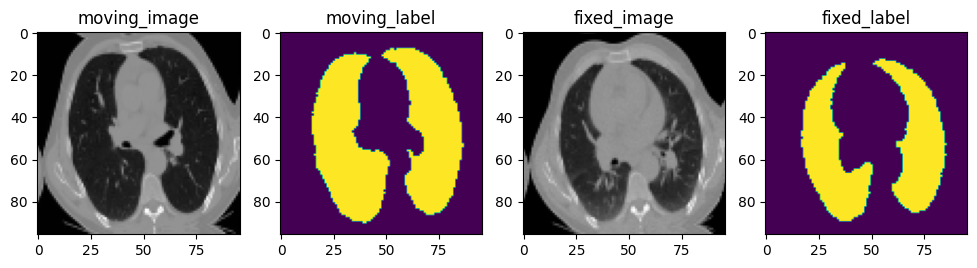

In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
fixed_label = check_data["fixed_label"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
moving_label = check_data["moving_label"][0][0].permute(1, 0, 2)

print(f"moving_image shape: {moving_image.shape}, "
      f"moving_label shape: {moving_label.shape}")
print(f"fixed_image shape: {fixed_image.shape}, "
      f"fixed_label shape: {fixed_label.shape}")

# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("moving_image")
plt.imshow(moving_image[:, :, 50], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("moving_label")
plt.imshow(moving_label[:, :, 50])
plt.subplot(1, 4, 3)
plt.title("fixed_image")
plt.imshow(fixed_image[:, :, 50], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("fixed_label")
plt.imshow(fixed_label[:, :, 50])

plt.show()
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.
To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.
If want to to try the regular Dataset, just change to use the commented code below.


In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,
                        cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms,
                      cache_rate=1.0, num_workers=0)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.68it/s]


#### Create Model, Loss and Optimizer

In [10]:
# standard PyTorch program style: create LocalNet, losses and optimizer
device = torch.device("cuda:0")
model = LocalNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    num_channel_initial=32,
    extract_levels=[3],
    out_activation=None,
    out_kernel_initializer="zeros").to(device)
warp_layer = Warp().to(device)
image_loss = MSELoss()
label_loss = DiceLoss()
label_loss = MultiScaleLoss(label_loss, scales=[0, 1, 2, 4, 8, 16])
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


Define a forward pass function for ddf computation and warping to avoid duplicate coding.

In [11]:
def forward(batch_data, model):
    fixed_image = batch_data["fixed_image"].to(device)
    moving_image = batch_data["moving_image"].to(device)
    moving_label = batch_data["moving_label"].to(device)

    # predict DDF through LocalNet
    ddf = model(torch.cat((moving_image, fixed_image), dim=1))

    # warp moving image and label with the predicted ddf
    pred_image = warp_layer(moving_image, ddf)
    pred_label = warp_layer(moving_label, ddf)

    return ddf, pred_image, pred_label

## Execute a typical PyTorch training process
Due to long training time required to for the model to converge, we provide a training snippet that trains for only 5 epochs to illustrate the training process.
Pretrained weight which has been trained for 2000 epochs are provided in the inference section to illustrated the final performance.
If want to train by yourself, simply change max_epochs to 2000.

In [12]:
max_epochs = 5
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    if (epoch + 1) % val_interval == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:

                val_ddf, val_pred_image, val_pred_label = forward(
                    val_data, model)
                val_pred_label[val_pred_label > 1] = 1

                val_fixed_image = val_data["fixed_image"].to(device)
                val_fixed_label = val_data["fixed_label"].to(device)
                dice_metric(y_pred=val_pred_label, y=val_fixed_label)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} "
                f"current mean dice: {metric:.4f}\n"
                f"best mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        ddf, pred_image, pred_label = forward(batch_data, model)
        pred_label[pred_label > 1] = 1

        fixed_image = batch_data["fixed_image"].to(device)
        fixed_label = batch_data["fixed_label"].to(device)
        loss = image_loss(pred_image, fixed_image) + 100 * \
            label_loss(pred_label, fixed_label) + 10 * regularization(ddf)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

saved new best metric model
current epoch: 1 current mean dice: 0.7976
best mean dice: 0.7976 at epoch: 1
----------
epoch 1/5


y_pred should be a binarized tensor.


epoch 1 average loss: 38.2276
current epoch: 2 current mean dice: 0.7973
best mean dice: 0.7976 at epoch: 1
----------
epoch 2/5
epoch 2 average loss: 38.4304
saved new best metric model
current epoch: 3 current mean dice: 0.7980
best mean dice: 0.7980 at epoch: 3
----------
epoch 3/5
epoch 3 average loss: 38.0425
saved new best metric model
current epoch: 4 current mean dice: 0.8048
best mean dice: 0.8048 at epoch: 4
----------
epoch 4/5
epoch 4 average loss: 38.1848
saved new best metric model
current epoch: 5 current mean dice: 0.8108
best mean dice: 0.8108 at epoch: 5
----------
epoch 5/5
epoch 5 average loss: 38.3294


In [13]:
print(f"train completed, "
      f"best_metric: {best_metric:.4f}  "
      f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8108  at epoch: 5


#### Plot the loss and metric

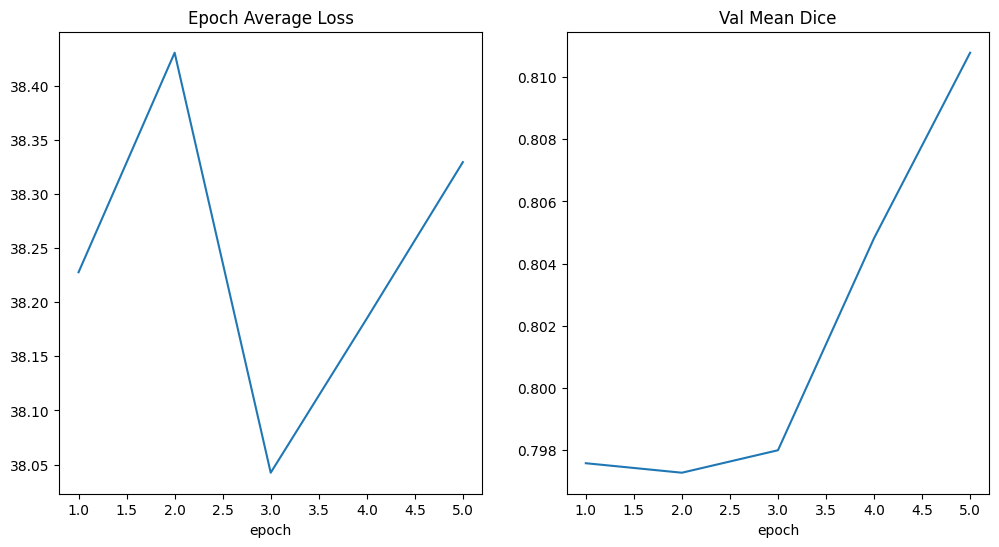

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Inference with the pretrained model

Download and load the pretrained weights.

In [15]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/pair_lung_ct.pth"
dst = f"{root_dir}/pretrained_weight.pth"
download_url(resource, dst)
model.load_state_dict(torch.load(dst))

2023-01-13 09:40:09,765 - INFO - Expected md5 is None, skip md5 check for file /workspace/data/medical/pretrained_weight.pth.
2023-01-13 09:40:09,765 - INFO - File exists: /workspace/data/medical/pretrained_weight.pth, skipped downloading.


<All keys matched successfully>

Inference with the pretrained weights and visualise the result at different depth.

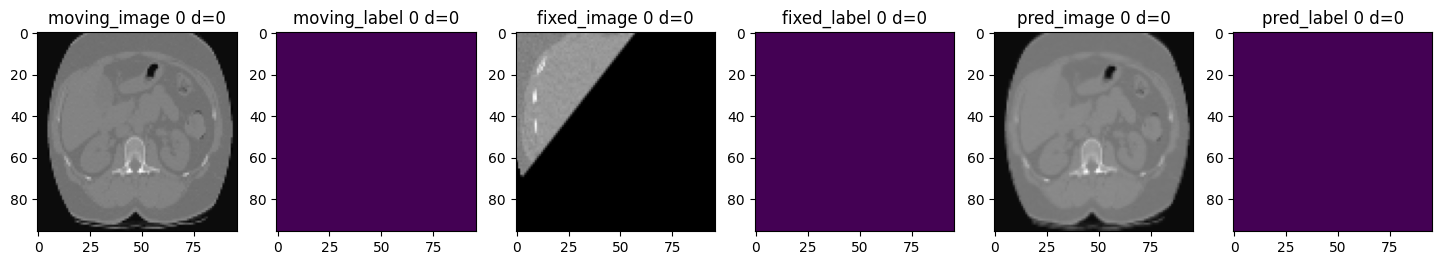

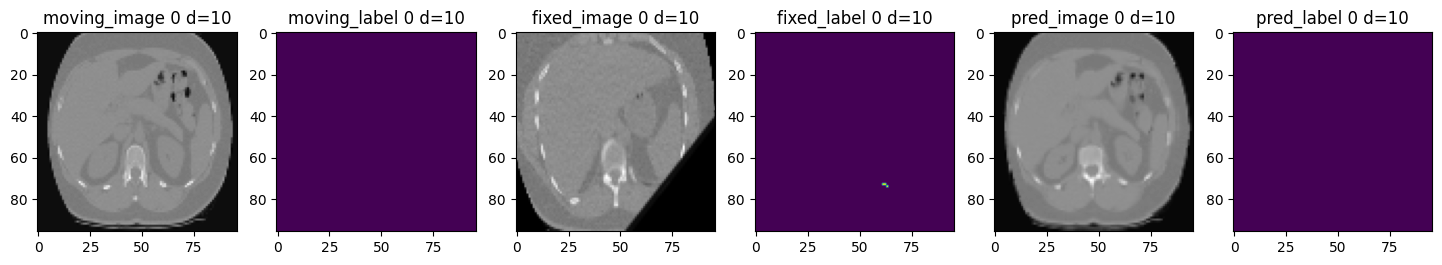

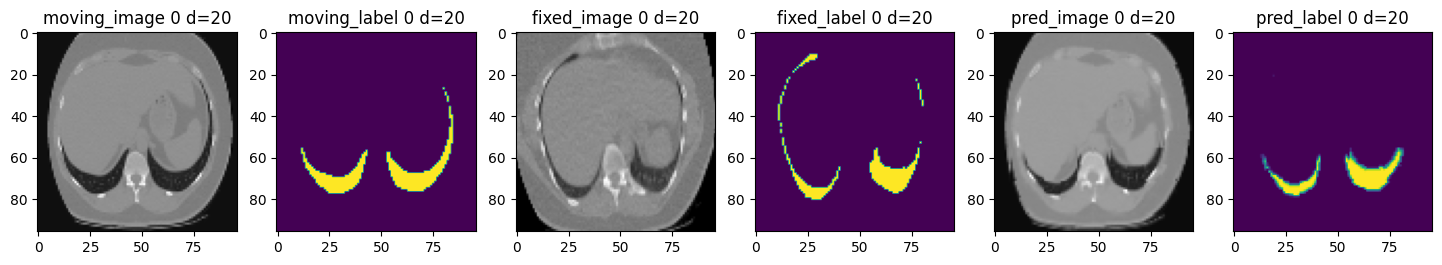

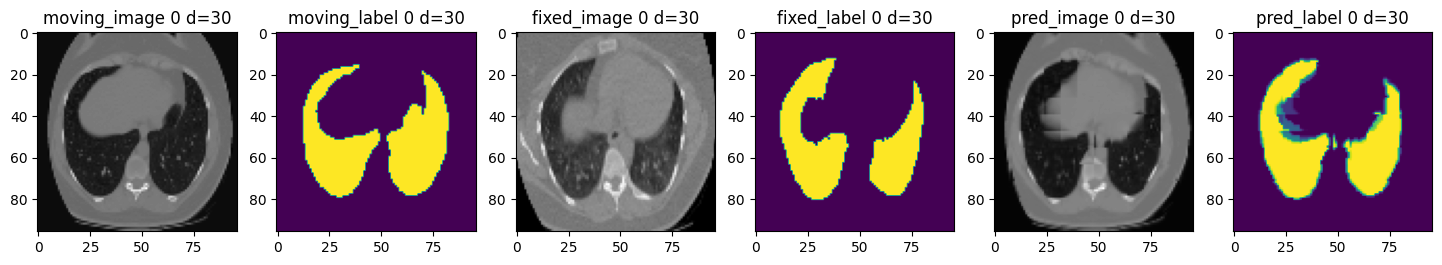

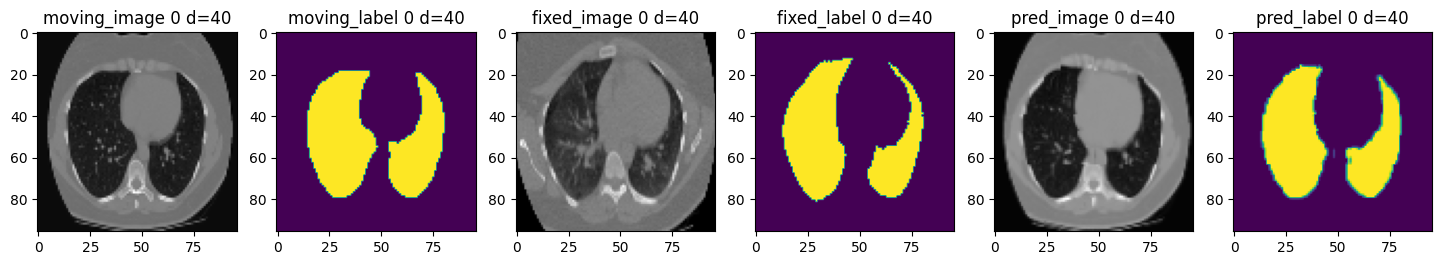

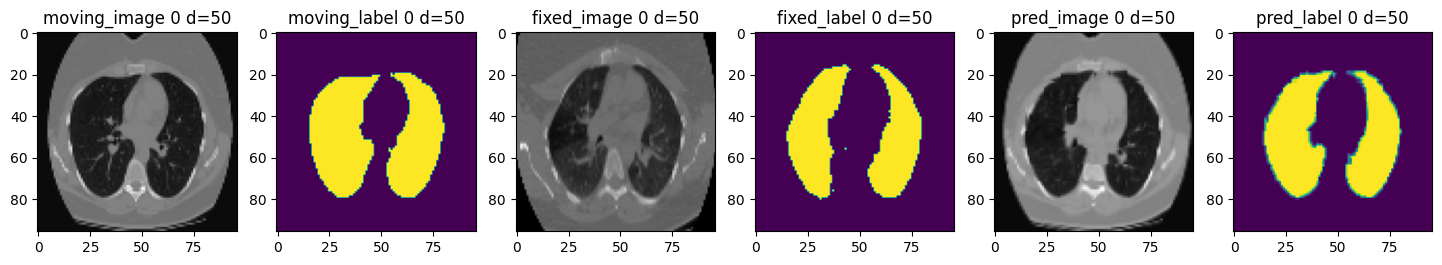

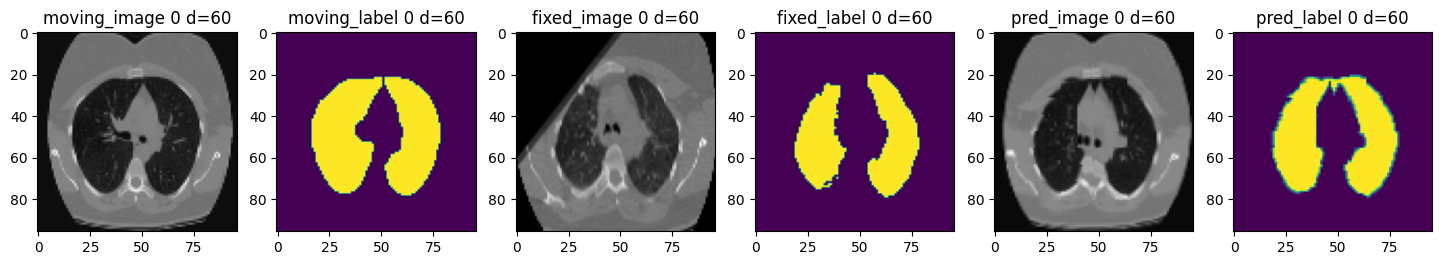

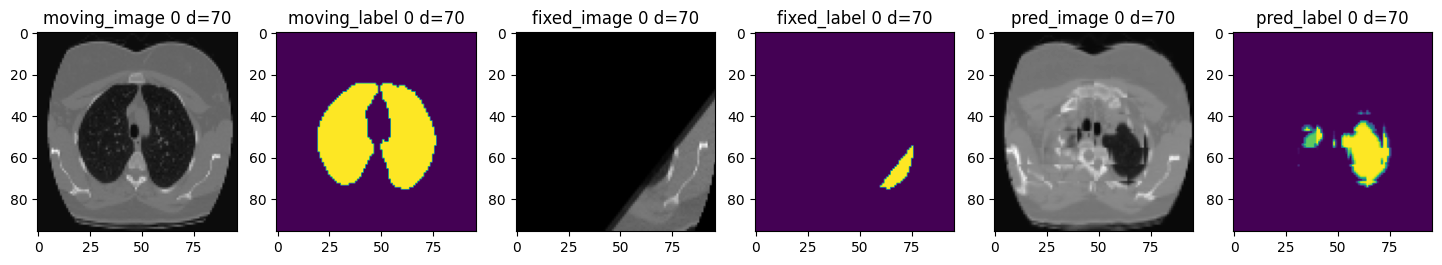

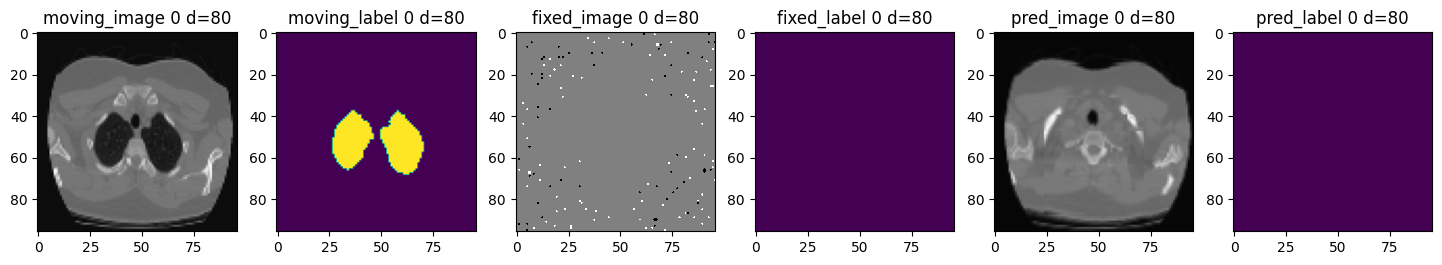

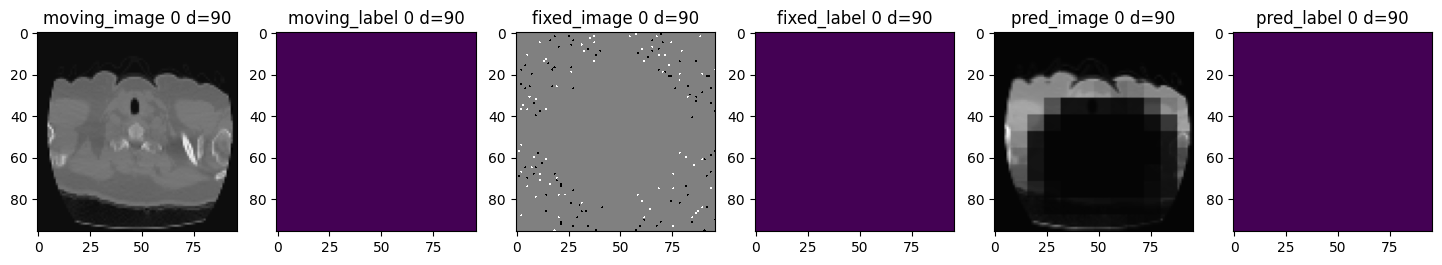

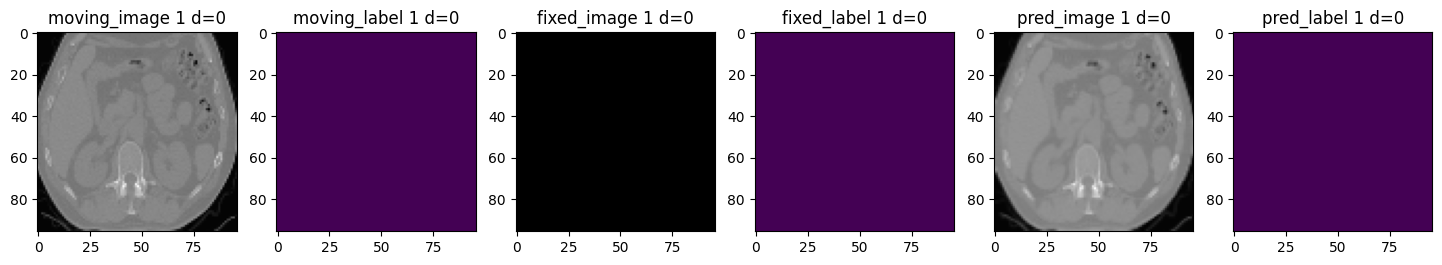

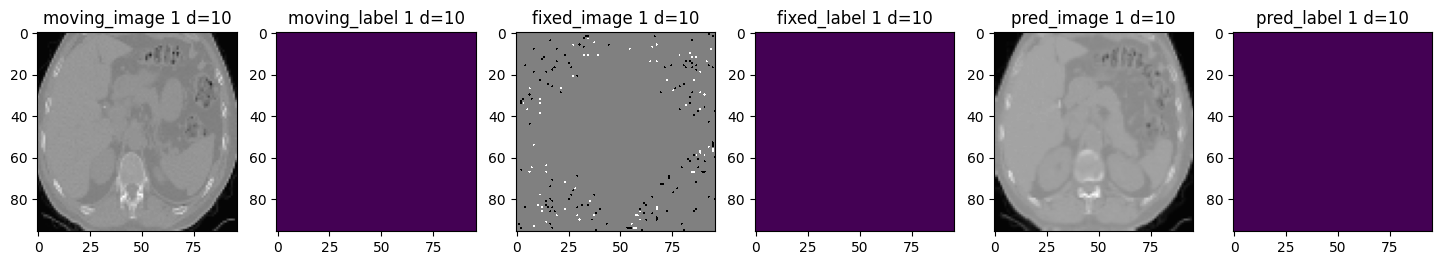

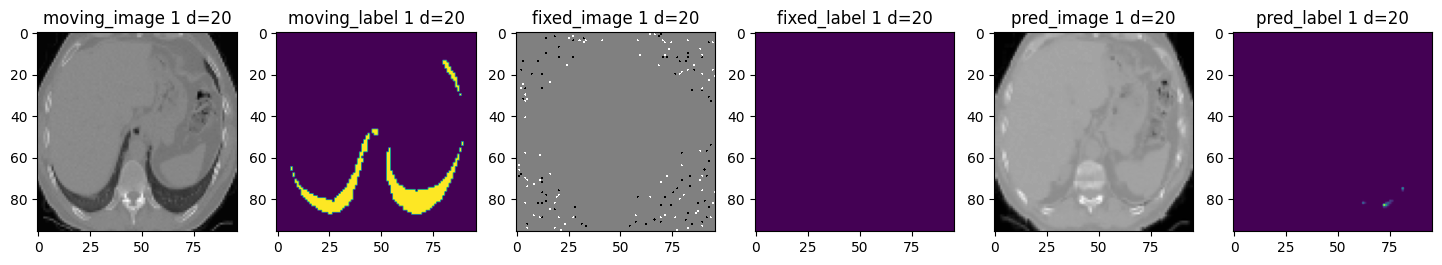

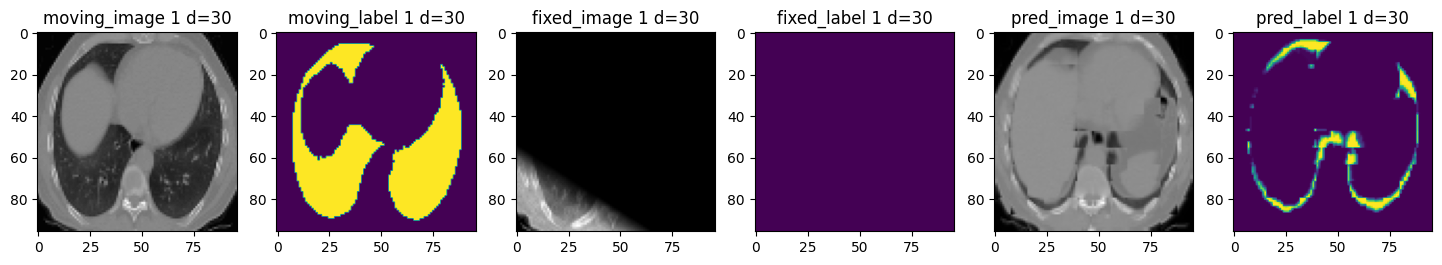

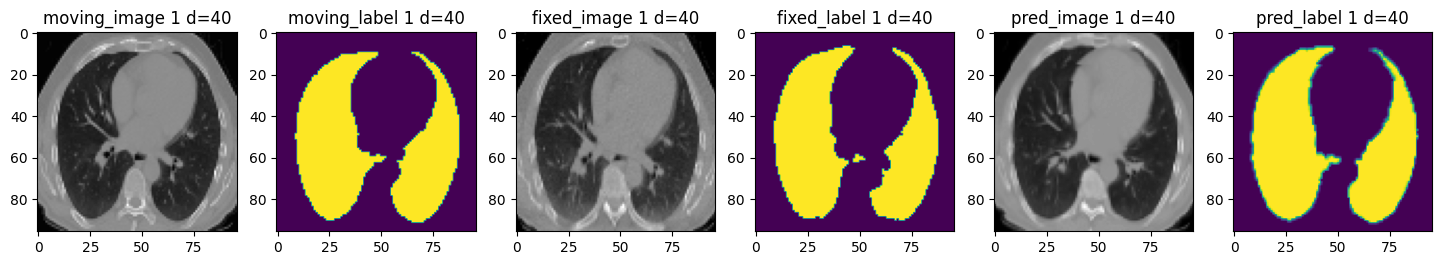

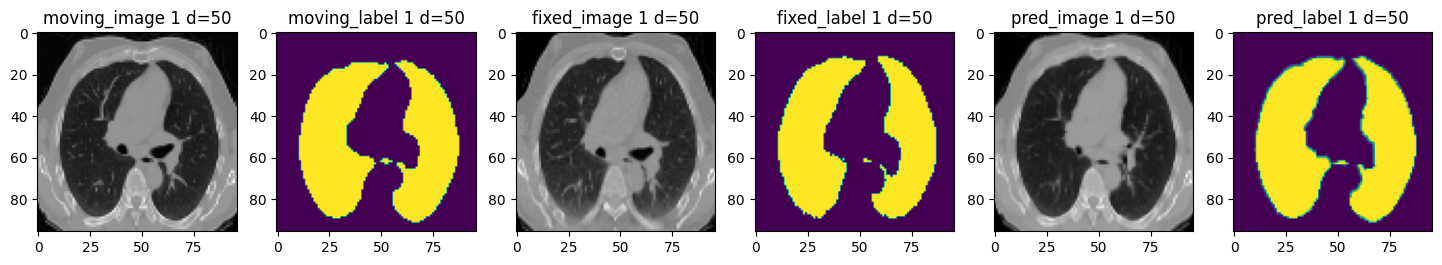

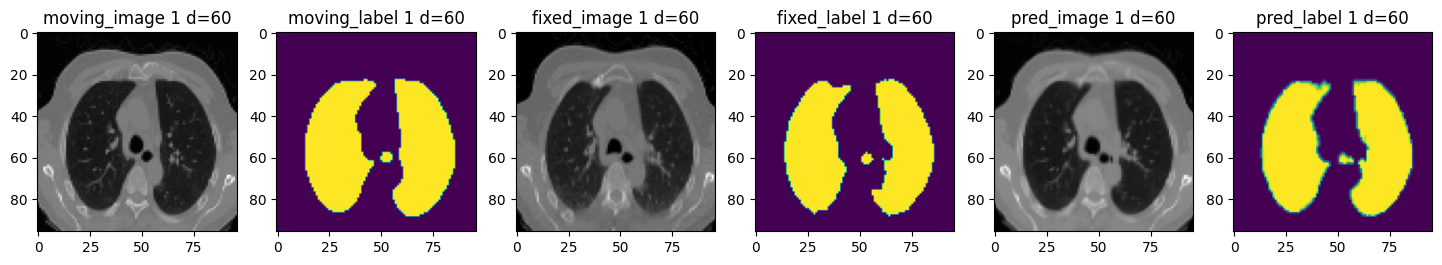

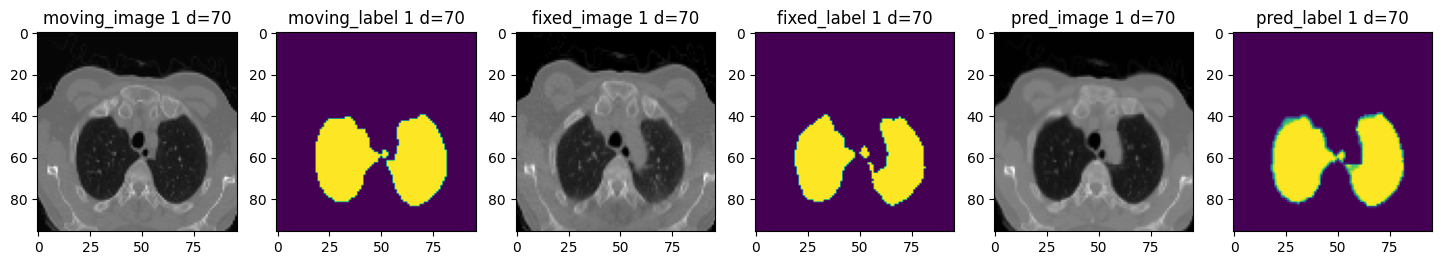

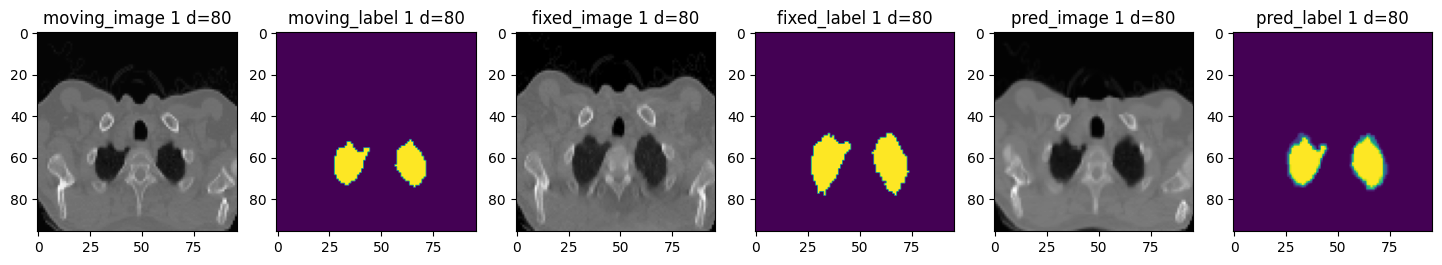

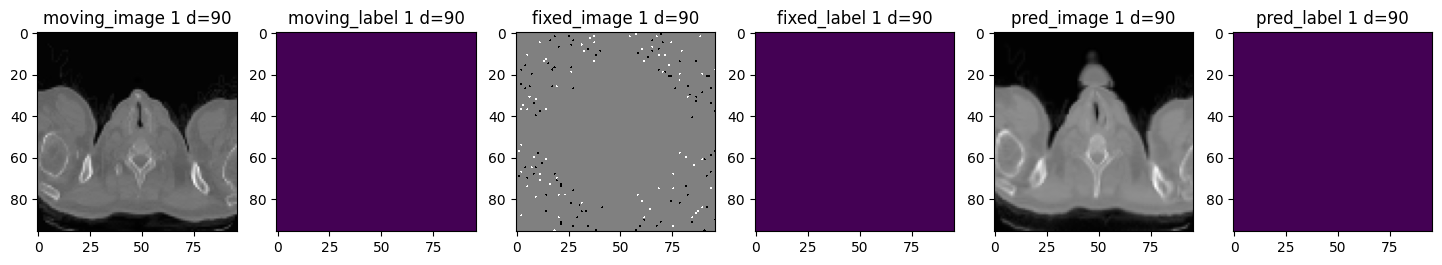

In [16]:
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i > 2:
            break
        val_ddf, val_pred_image, val_pred_label = forward(val_data, model)
        val_pred_image = val_pred_image.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_pred_label = val_pred_label.cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_image = val_data["moving_image"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_moving_label = val_data["moving_label"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_image = val_data["fixed_image"].cpu().numpy()[0, 0].transpose((1, 0, 2))
        val_fixed_label = val_data["fixed_label"].cpu().numpy()[0, 0].transpose((1, 0, 2))

        for depth in range(10):
            depth = depth * 10
            # plot the slice [:, :, 80]
            plt.figure("check", (18, 6))
            plt.subplot(1, 6, 1)
            plt.title(f"moving_image {i} d={depth}")
            plt.imshow(val_moving_image[:, :, depth], cmap="gray")
            plt.subplot(1, 6, 2)
            plt.title(f"moving_label {i} d={depth}")
            plt.imshow(val_moving_label[:, :, depth])
            plt.subplot(1, 6, 3)
            plt.title(f"fixed_image {i} d={depth}")
            plt.imshow(val_fixed_image[:, :, depth], cmap="gray")
            plt.subplot(1, 6, 4)
            plt.title(f"fixed_label {i} d={depth}")
            plt.imshow(val_fixed_label[:, :, depth])
            plt.subplot(1, 6, 5)
            plt.title(f"pred_image {i} d={depth}")
            plt.imshow(val_pred_image[:, :, depth], cmap="gray")
            plt.subplot(1, 6, 6)
            plt.title(f"pred_label {i} d={depth}")
            plt.imshow(val_pred_label[:, :, depth])
            plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [17]:
if directory is None:
    shutil.rmtree(root_dir)